## 线下零售贷款申请客户特征处理-申请信息特征

In [1]:
import pandas as pd
from feature_selector import FeatureSelector
import matplotlib.pyplot as plt
import numpy as np
import pylab
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
import math
import datetime
import scorecardpy as sc
import scipy
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,train_test_split
import seaborn as sns
import warnings
from sklearn.metrics import roc_auc_score,roc_curve
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  
pd.set_option('max.columns',200)
warnings.filterwarnings('ignore')

In [2]:
main_dataset = pd.read_csv('main_fea_origin_1.csv',encoding='gbk')

# 一、数据清洗

In [3]:
train_dt = main_dataset[main_dataset['基准时间'] <= '2019-08-31']
test_oot = main_dataset[main_dataset['基准时间'] > '2019-08-31']

In [4]:
train_dt = train_dt.loc[:,~train_dt.columns.str.contains('客编')]
test_oot = test_oot.loc[:,~test_oot.columns.str.contains('客编')]
# 查看数据缺失比例,删除缺失超过85%的特征
fs = FeatureSelector(data=main_dataset.drop(['tag'],axis=1), labels=main_dataset['tag'])
fs.identify_missing(0.8)
train_dt = train_dt.drop(fs.ops['missing'],axis=1)
test_oot = test_oot.drop(fs.ops['missing'],axis=1)

54 features with greater than 0.80 missing values.



In [5]:
tra_x,test_x,tra_y,test_y = train_test_split(train_dt,train_dt['tag'],test_size=0.2,stratify=train_dt['tag'],random_state=123)
test_x['oot'] = 0
test_oot['oot'] = 1
test_x = pd.concat([test_x,test_oot],axis=0)
test_y = pd.concat([test_y,test_oot['tag']],axis=0)

In [6]:
test_x['tag'].value_counts()

0    3405
1     109
Name: tag, dtype: int64

In [7]:
test_x.shape

(3514, 185)

In [8]:
tra_x['tag'].value_counts()

0    2474
1     166
Name: tag, dtype: int64

In [9]:
tra_x.shape

(2640, 184)

In [10]:
drop_feas = ['基准时间','配偶证件号码_y','mr_婚姻状况','mr_年龄','行业大类（可否聚类分析）','单位性质.1','最高学历.1','雇佣状态.1',
             '用款主体客户名称','发证日期','行业大类','单位所属行业.1']
tra_x.drop(drop_feas,axis=1,inplace=True)
test_x.drop(drop_feas,axis=1,inplace=True)

In [11]:
tra_x.drop(['授信申请编号','借款人身份证','起始日','成立日期','配偶客户名称','证件号码','配偶身份证'],
              axis=1,inplace=True)
test_x.drop(['授信申请编号','借款人身份证','起始日','成立日期','配偶客户名称','证件号码','配偶身份证'],
              axis=1,inplace=True)

In [12]:
# 输出类别变量及其对应的分类个数
def get_features_type(xfea):
    types_ser = xfea.dtypes
    cat_feas = types_ser[(types_ser == object)|(types_ser == str)].index
    cat_feas_dic = {c: len(xfea[c].unique()) for c in cat_feas}
    num_feas = types_ser[(types_ser==float)].index
    num_feas_dic = {n: len(xfea[n].unique()) for n in num_feas if len(xfea[n].unique()) >= 3}
    return {'cat_feas':pd.Series(cat_feas_dic),'num_feas':pd.Series(num_feas_dic)}
#  小于5个分类的类别变量，无需分箱，直接计算woe,iv
def clean_binning_cate(bin_df):
    drop_cats = []
    cat_bin_dic = {}
    for b in bin_df:
        if b['IV'][0] < 0.5:
            cat_bin_dic[b.index.name] = b['woe'].to_dict()
        else:
            drop_cats.append(b.index.name)
    return drop_cats,cat_bin_dic

def BinBadRate(df, col, target,return_type='badrate'):
    '''
    :param df: 需要计算好坏比率的数据集
    :param col: 需要计算好坏比率的特征
    :param target: 好坏标签
    :param grantRateIndicator: 1返回总体的坏样本率，0不返回
    :return: 每箱的坏样本率，以及总体的坏样本率（当grantRateIndicator＝＝1时）
    '''
    regroup = df.groupby([col])['tag'].agg(['count','sum'])# 每箱的坏样本数，总样本数
    regroup.columns = ['total','bad']
    regroup.reset_index(level=0, inplace=True)
    regroup['good'] = regroup['total'] - regroup['bad']
    regroup['badrate'] = regroup['bad']/regroup['total']
    regroup['badattr'] = regroup['bad']/regroup['bad'].sum()
    regroup['goodattr'] = regroup['good']/regroup['good'].sum()
    regroup['woe'] = np.log(regroup['badattr']) - np.log(regroup['goodattr'])
    regroup['bin_iv'] = (regroup['badattr'] - regroup['goodattr'])*regroup['woe']
    regroup['total_iv'] = regroup.loc[(regroup['bin_iv'] != np.inf) | (regroup['bin_iv'] != np.inf),'bin_iv'].sum()
    if return_type == 'badrate':
        dicts = dict(zip(regroup[col],regroup['badrate'])) # 每箱对应的坏样本率组成的字典
    else:
        dicts = dict(zip(regroup[col],regroup['woe'].replace({-np.inf:0,np.inf:0})))
    return dicts, regroup

def BinWoeEncoding(df,col,target):
    woebin_dict,bin_df = regroup = BinBadRate(df, col, target, return_type='woe')
    return woebin_dict,bin_df

In [13]:
all_feas_info = get_features_type(tra_x)
cat_feas = all_feas_info['cat_feas']
num_feas = all_feas_info['num_feas']
cat_feas_1 = cat_feas[(cat_feas>6)&(cat_feas<100)]
cat_feas_2 = cat_feas[cat_feas <= 6]

# 2.特征分箱

## 1.1 连续变量分箱-决策树分箱

In [14]:
# 决策树分箱函数
def rf_bins_num(df,num_cols,target):
    print('randomforest cut bins...')
    bin_dicts={}
    woebin_list=[]
    for var in num_cols:
        try:
            bins0=sc.woebin(df,y=target,x=[var])
            init_bins=bins0[var].breaks.tolist()
            try:
                init_bins.remove('missing')
                init_bins.remove('inf')
            except:
                pass
            final_bins=[round(float(i),4) for i in init_bins]
            bins=sc.woebin(df,y=target,x=[var],breaks_list={var:final_bins})
            bin_dicts.update(bins)
        except:
            woebin_list.append(var)
    return bin_dicts,woebin_list

def get_numfeas(df):
    type_ser = df.dtypes
    numFeas = type_ser[(type_ser == 'float')|(type_ser == 'int')]
    numFeas = {c : len(df[c].unique()) for c in numFeas.index}
    numFeas = pd.Series(numFeas)
    return numFeas[numFeas>=6],numFeas[numFeas<6]

def check_monotony(x):
    return (np.sign(x['badprob'].diff()).sum() == (x.shape[0]-1))or(np.sign(x['badprob'].diff()).sum() == -(x.shape[0]-1))

def filter_fea(bin_dic,iv_threshold=0.2,mono=True):
    fea_info_list = []
    for k,v in bin_dic.items():
        mono_status = check_monotony(v)
        iv = v['total_iv'][0]
        fea_info_list.append([k,mono_status,iv])
    fea_info = pd.DataFrame.from_records(fea_info_list,columns=['variable','mono_status','iv'])
    fea_info = fea_info.set_index('variable')
    return fea_info

def bin_save(bin_info,filename='bin_info.xlsx'):
    with pd.ExcelWriter(filename) as writer:
        for n,d in bin_info.items():
            d.to_excel(writer, sheet_name=n)

In [15]:
# 逾期与查询相关的特征空缺用0填充
tra_x.loc[:,tra_x.columns.str.contains('逾期|查询')] = tra_x.fillna(0)
test_x.loc[:,test_x.columns.str.contains('逾期|查询')] = test_x.fillna(0)
tra_x['贷款额度比率'] = tra_x['平均额度']/tra_x['授信总额']
test_x['贷款额度比率'] = test_x['平均额度']/tra_x['授信总额']

In [16]:
need_drop_feas = list(cat_feas_2.index)
need_drop_feas.extend(['是否可循环','户籍地与居住地市级是否一致','近6月最大逾期','雇佣状态','担保方式',
                       '押品类型','单位性质','婚姻状况','最高学历','本人居住地址是否与配偶住址一致','户籍地与居住地区级是否一致',
                       'mr_性别','配偶是否有单位记录','rep_name_equal_ctrl_name','单位所属行业','性别','是否有保证','征信白户',
                       'mr_征信白户','work_place_equal_resdnt_place','work_place_equal_birth_place','是否保证加抵押',
                       '贷款六个月内M7次数','贷款十二个月内M4次数','贷款六个月内M4次数','担保金额','birth_year',
                       '贷款三个月内M7次数','期限','贷款三个月内M4次数','综合抵押率','收入合计','注册资本','年审频率',
                       '贷款十二个月内M7次数','保证金额','年龄','学历','mr_学历','配偶年龄','found_until_apply_days',
                       'found_until_apply_years'])
tra_x = tra_x.loc[:,~tra_x.columns.str.contains('行政区划')]

test_x = test_x.loc[:,~test_x.columns.str.contains('行政区划')]
test_x.drop(need_drop_feas,axis=1,inplace=True)
tra_x.drop(need_drop_feas,axis=1,inplace=True)

In [17]:
num_feas1,num_feas2 = get_numfeas(tra_x)
num_feas1 = list(num_feas1.index)

In [18]:
num_feas2

当前逾期              1
mr_当前逾期           1
mr_近3月最大逾期        4
mr_近6月最大逾期        5
mr_近12月最大逾期       5
mr_贷款三个月内M2次数     2
mr_贷款三个月内M3次数     2
mr_贷款三个月内M4次数     2
mr_贷款三个月内M7次数     2
mr_贷款六个月内M2次数     2
mr_贷款六个月内M3次数     2
mr_贷款六个月内M4次数     2
mr_贷款六个月内M7次数     2
mr_贷款十二个月内M2次数    2
mr_贷款十二个月内M3次数    2
mr_贷款十二个月内M4次数    2
mr_贷款十二个月内M7次数    2
还款间隔              5
dtype: int64

In [19]:
tra_x.shape

(2640, 113)

In [20]:
for n in num_feas2.index:
    bin_dict,bin_df = BinWoeEncoding(tra_x,col=n,target='tag')
#     bin_dicts[n] = bin_dict
#     bin_df_dicts[n] = bin_df
    tra_x[n] = tra_x[n].replace(bin_dict)
    test_x[n] = test_x[n].replace(bin_dict)

In [21]:
import os 
import pickle 
os.path.exists('rf_bins_dic.pickle')

True

In [22]:
# sc.woebin_plot(sc.woebin(tra_x,x=['近2年内查询次数-担保资格审查'],y='tag',breaks_list={'近2年内查询次数-担保资格审查':[1,2]}))

In [23]:
# 决策树分箱并进行woe编码
rf_bins_dic = sc.woebin(tra_x,x=num_feas1,y='tag')
tra_x_woe = sc.woebin_ply(tra_x, rf_bins_dic)
test_x_woe = sc.woebin_ply(test_x, rf_bins_dic)

[INFO] creating woe binning ...
Binning on 2640 rows and 95 columns in 00:00:45
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [24]:
# 对决策树分箱后的连续变量进行初步筛选，iv>0.1,woe单调
filter_fea_df = filter_fea(rf_bins_dic)
adj_feas = set(filter_fea_df.loc[filter_fea_df['iv'] < 0.01].index)
select_feas = set(filter_fea_df.index)-adj_feas

In [25]:
# 根据业务逻辑对部分特征分箱进行调整
adj_bins = {'found_until_apply_month':['missing',15,20,25,50],
           '平均额度':[10000,15000,25000],'mr_平均额度':[10000,45000],'近5年累计逾期':[1,3,4],
            '近2年内查询次数-担保资格审查':[1,2]}
rf_adj_bins = sc.woebin(tra_x,y='tag',x=['found_until_apply_month','平均额度','mr_平均额度','近5年累计逾期'],
                        breaks_list=adj_bins)
rf_bins_dic.update(rf_adj_bins)

[INFO] creating woe binning ...


In [26]:
tra_x_woe = sc.woebin_ply(tra_x,rf_bins_dic)
test_x_woe = sc.woebin_ply(test_x,rf_bins_dic) 

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [27]:
select_feas = select_feas |{'found_until_apply_month','非银金融机构未结清贷款笔数','发卡法人机构总数','未结清贷款余额',
              '近6月平均使用额度','贷记透支比例','贷款历史机构数','贷款最大还款月数','贷款最大剩余月数'}

In [28]:
filter_fea_df_adj = filter_fea(rf_bins_dic)
filter_fea_df_adj.reindex(select_feas).sort_values(['iv'])

,mono_status,iv
variable,,
mr_对外担保余额,False,0.011373
mr_担保本金余额,False,0.011373
mr_近24月最大逾期,True,0.011994
mr_平均额度,False,0.012032
mr_近5年累计逾期,False,0.013227
...,...,...
近6月内查询机构数-贷款审批,True,0.640525
近12月内查询次数-贷款审批,True,0.706827
近12月内查询机构数-贷款审批,True,0.749198


In [29]:
sns.set_style('darkgrid')

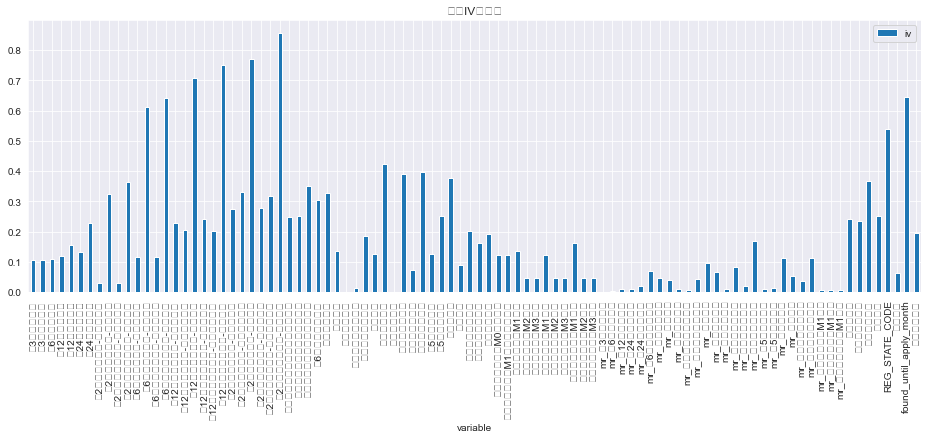

In [30]:
filter_fea_df.plot.bar(figsize=(16,5),title='特征IV值分布')

In [31]:
adj_feas = set(filter_fea_df_adj.index) - select_feas
# tra_x_woe.drop(rf_drop_feas,axis=1,inplace=True)
tra_x_woe.drop([i + '_woe' for i in adj_feas],axis=1,inplace=True)
# test_x_woe.drop(rf_drop_feas,axis=1,inplace=True)
test_x_woe.drop([i + '_woe' for i in adj_feas],axis=1,inplace=True)

# 3. 特征筛选

In [32]:
import statsmodels.api as sm

# 显著性筛选,在筛选前需要做woe转换
def forward_delete_pvalue(x_train,y_train):
    """
    x_train -- x训练集
    y_train -- y训练集
    
    return :显著性筛选后的变量
    """
    col_list = list(x_train.columns)
    pvalues_col=[]
    for col in col_list:
        print(col)
        pvalues_col.append(col)
        x_train2 = sm.add_constant(x_train.loc[:,pvalues_col])
        sm_lr = sm.Logit(y_train,x_train2)
        try:
            sm_lr = sm_lr.fit()
        except:
            continue
        for i,j in zip(sm_lr.pvalues.index[1:],sm_lr.pvalues.values[1:]): 
            if j>=0.2:
                pvalues_col.remove(i)
    x_new_train = x_train.loc[:,pvalues_col]
    x_new_train2 = sm.add_constant(x_new_train)
    lr = sm.Logit(y_train,x_new_train2)
    lr = lr.fit()
    return pvalues_col

# xgboost筛选变量 
def select_xgboost(df,target,imp_num=None):
    """
    df:数据集
    target:目标变量的字段名
    imp_num:筛选变量的个数
    
    return:
    xg_fea_imp:变量的特征重要性
    xg_select_col:筛选出的变量
    """
    x = df.drop([target],axis=1)
    y = df[target]
    xgmodel = XGBClassifier(random_state=0)
    xgmodel = xgmodel.fit(x,y,eval_metric='auc')
    xg_fea_imp = pd.DataFrame({'col':list(x.columns),
                               'imp':xgmodel.feature_importances_})
    xg_fea_imp = xg_fea_imp.sort_values('imp',ascending=False).reset_index(drop=True).iloc[:imp_num,:]
    xg_select_col = list(xg_fea_imp.col)
    return xg_fea_imp,xg_select_col

#逐步回归
def score_test(x_data,y_data,y_pred,DF=1):
    x_arr=np.matrix(x_data)
    y_arr=np.matrix(y_data).reshape(-1,1)
    yh_arr=np.matrix(y_pred).reshape(-1,1)
    grad_0=-x_arr.T * (y_arr-yh_arr)
    info_0=np.multiply(x_arr,np.multiply(yh_arr,(1-yh_arr))).T * x_arr
    cov_m=info_0**(-1)
    chi2_0=grad_0.T * cov_m * grad_0
    Pvalue=(1-scipy.stats.chi2.cdf(chi2_0[0,0],DF))
    return(chi2_0[0,0],DF,Pvalue)

#定义异常
class paraException(BaseException):
    def __init__(self,mesg="raise a myException"):
        print(mesg)
        
def step_logit(x_in, y_in, selection='stepwise',sle=0.1,sls=0.1,includes=[]):
    ###检查x和y的长度
    if len(x_in) != len(y_in):
        raise paraException(mesg='x,y长度不一致!')
    x_data = x_in.copy()
    y_data = y_in.copy()
    if isinstance(x_data,pd.core.frame.DataFrame) == True:
        x_list = list(x_data.columns.copy())
    elif isinstance(x_data,np.ndarray) == True:
        if len(x_data.shape) == 1:
            x_list = ['x_0']
            x_data = pd.DataFrame(x_data.reshape(-1,1),columns=x_list)
        elif len(x_data.shape) == 2:
            x_list = ['x_' + str(i) for i in np.arange(x_data.shape[1])]
            x_data = pd.DataFrame(x_data,columns=x_list)
        else:
            raise paraException(mesg='x有问题!')
    else:
        raise paraException(mesg='x有问题!')
    # 处理强制进入变量
    try:
        if (includes>0) and (includes>0) :
            includes = x_list[:includes].copy()
        else:
            includes = []
    except:
        pass
    # 处理x,y
    x_data['_const']=1
    if (isinstance(y_data,pd.core.frame.DataFrame) == True) or (isinstance(y_data,pd.core.series.Series) == True):
        y_data = y_data.values.reshape(-1,1)
    else:
        y_data = y_data.reshape(-1,1)
    # stepwise
    if selection.upper() == 'STEPWISE':
        include_list = ['_const'] + includes
        current_list = []
        candidate_list = [_x for _x in x_list if _x not in include_list]
		##第一次拟合
        lgt = sm.Logit(y_data,x_data[include_list])
        res = lgt.fit()
		##预测结果
        y_pred = res.predict()
		####输出第一步的拟合结果以及卡方检验结果
        print('========================第0步结果=======================')
        print(res.summary2())
        print(res.wald_test_terms())
		##循环增删变量
        STOP_FLAG = 0 
        step_i = 1
        while(STOP_FLAG == 0):
            if len(candidate_list) == 0:
                break
			##遍历所有候选变量，计算每一个加入的候选变量对应的score统计量
            score_list = [score_test(x_data[include_list + current_list +[x0]]
									,y_data
									,y_pred)
							for x0 in candidate_list]
            score_df = pd.DataFrame(score_list,columns=['chi2','df','p-vlue'])
            score_df['xvar'] = candidate_list
            slt_idx = score_df['chi2'].idxmax()
            p_value = score_df['p-vlue'].iloc[slt_idx]
            enter_x = candidate_list[slt_idx]
			###
			####输出第i步的候选变量的score统计量
            print('#####======第' + str(step_i) + '步：候选变量的遍历结果=======')
            print(score_df[['xvar','chi2','df','p-vlue']])
            if p_value <= sle:
                current_list.append(enter_x)   ##加入模型列表
                candidate_list.remove(enter_x) ##从候选变量列表平中删除
                print('######====第' + str(step_i) + '步：加入变量' + enter_x)
            else:
                STOP_FLAG = 1
                print('######====第' + str(step_i) + '步：未加入变量')
			##根据新的变量列表，重新拟合，查看是否所有变量都能保留
            lgt = sm.Logit(y_data,x_data[include_list+current_list])
            res = lgt.fit()
			##预测结果
            y_pred = res.predict()
			##wald chi2 test
            chi2_df = res.wald_test_terms().table.copy()
			##检查是否有变量需要删除
            tmp_del_list = [tmp_x for tmp_x in chi2_df.index if tmp_x not in include_list]
			####输出第i步的候选变量的score统计量
            print('######======第' + str(step_i) + '步：wald卡方检验======')
			#print(res.wald_test_terms())
			##如果p-value大于等于sls,删除最大的
            if len(tmp_del_list) > 0:
                tmp_chi2 = chi2_df.loc[tmp_del_list].sort_values(by='statistic')
                if tmp_chi2['pvalue'].iloc[0] >sls:
                    del_x = tmp_chi2.index[0]
					##打印结果
                    print('######====第' + str(step_i) + '步：删除变量' + del_x)
					##如果删除的是最近加入的变量，则停止筛选
                    if del_x == current_list[-1]:
                        current_list.remove(del_x)
                        STOP_FLAG = 1
                    else:
                        current_list.remove(del_x)
					##删除的变量加入候选变量列表中
                    candidate_list.append(del_x)
					
					###根据删除后的变量列表再次拟合
                    lgt = sm.Logit(y_data,x_data[include_list+current_list])
                    res = lgt.fit()
					##预测结果
                    y_pred = res.predict()
                else:
                    print('######====第' + str(step_i) + '步：未删除变量' )
            else:
                print('######====第' + str(step_i) + '步：未删除变量' )
            print('########################################')
            print()
            step_i += 1
        print('========================最终结果汇总=======================')
        print(res.summary2())
        print(res.wald_test_terms())
        all_cols = list(x_in)
        all_params = list(res.params.index)
        remove_cols = [f for f in all_cols if f not in all_params]
        return remove_cols,res
	####简单逻辑回归
    else:
        lgt = sm.Logit(y_data,x_data)
        res = lgt.fit()
        print('========================最终结果汇总=======================')
        print(res.summary2())
        print(res.wald_test_terms())
        return res
    
def check_vif(df,vif_threshold=5):
    from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
    xdf = sm.add_constant(df)
    vif_list = []
    xcols = list(xdf)
    vif_list = [vif(xdf.values,xcols.index(c)) for c in xcols[1:]]
    vif_ser = pd.Series(vif_list,index=xcols[1:])
    vif_drop_feas = list(vif_ser[vif_ser > 5].index)
    vif_ser.to_csv('特征VIF分析.csv',encoding='GBK')
    print('{0} features with a variance_inflation_factor greater than {1}'.format(len(vif_drop_feas),vif_threshold))
    return vif_drop_feas

def check_collinear(df,iv_df,corr_threshold=0.6):
    corr_df = df.corr()
    corr_df = corr_df.dropna(how='all',axis=1)
    corr_df = corr_df.dropna(how='all',axis=0)
    corr_df_melt = corr_df.unstack().reset_index()
    corr_df_melt.columns=['v1','v2','corr']
    corr_df_melt = corr_df_melt.drop_duplicates(subset='corr')
    corr_df_melt = corr_df_melt[(abs(corr_df_melt['corr']) > corr_threshold)&(corr_df_melt['v1'] != corr_df_melt['v2'])]
    new_corr_df_melt = corr_df_melt.set_index('v1').merge(iv_df,left_index=True,right_index=True,how='left').reset_index().set_index('v2')
    new_corr_df_melt = new_corr_df_melt.merge(iv_df,left_index=True,right_index=True,how='left')
    new_corr_df_melt = new_corr_df_melt.reset_index()
    new_corr_df_melt.columns=['v2','v1','corr','iv1','iv2']
    new_corr_df_melt = new_corr_df_melt.assign(n=lambda x:x.iv2-x.iv1)
    new_corr_df_melt['drop_feas'] = new_corr_df_melt.apply(lambda x: x[1] if x[-1] > 0 else x[0],axis=1)
    colinear_drop_feas = list(new_corr_df_melt['drop_feas'].unique())
    print('{0} features with a correlation magnitude greater than {1}'.format(len(colinear_drop_feas),corr_threshold))
    return colinear_drop_feas

In [33]:
tra_x_woe.loc[:,tra_x_woe.columns.str.contains('次数')] = tra_x_woe.fillna(0)
test_x_woe.loc[:,test_x_woe.columns.str.contains('次数')] = test_x_woe.fillna(0)

In [34]:
# 
all_iv_df = sc.iv(tra_x_woe,y='tag').set_index('variable')
all_iv_drop_feas = all_iv_df[all_iv_df['info_value'] <= 0.01].index
tra_x_woe.drop(all_iv_drop_feas,axis=1,inplace=True)
test_x_woe.drop(all_iv_drop_feas,axis=1,inplace=True)
# drop_feas.extend(all_iv_drop_feas)

In [35]:
# 相关性筛选
colliner_drop_feas = check_collinear(tra_x_woe,all_iv_df,0.7)
tra_x_woe.drop(colliner_drop_feas,axis=1,inplace=True)
test_x_woe.drop(colliner_drop_feas,axis=1,inplace=True)

39 features with a correlation magnitude greater than 0.7


In [36]:
if '非银金融机构信贷历史机构数_woe' in drop_feas:
    drop_feas.remove('非银金融机构信贷历史机构数_woe')

In [37]:
test_x_woe = test_x_woe.drop('tag',axis=1)
tra_x_woe = tra_x_woe.drop('tag',axis=1)
tra_x_woe.drop('还款间隔',axis=1,inplace=True)
test_x_woe.drop('还款间隔',axis=1,inplace=True)

In [38]:
tra_y = tra_y.sort_index()
tra_x_woe = tra_x_woe.sort_index()
test_y = test_y.sort_index()
test_x_woe = test_x_woe.sort_index()

In [39]:
# VIF筛选
vif_drop_feas = check_vif(tra_x_woe)
tra_x_woe.drop(vif_drop_feas,axis=1,inplace=True)
test_x_woe.drop(vif_drop_feas,axis=1,inplace=True)

7 features with a variance_inflation_factor greater than 5


In [40]:
# 11.21测试
# tra_x_woe.drop(["mr_担保本金余额_woe"],axis=1,inplace=True)
# test_x_woe.drop(["mr_担保本金余额_woe"],axis=1,inplace=True)

In [41]:
# 逐步回归筛选特征
# step_remove_feas = forward_delete_pvalue(tra_x_woe,tra_y)
step_remove_feas,res = step_logit(tra_x_woe,tra_y)
tra_x_woe.drop(step_remove_feas,axis=1,inplace=True)
test_x_woe.drop(step_remove_feas,axis=1,inplace=True)

还款月数_woe   0.593394   1  0.441110
27       mr_贷款最大还款月数_woe  10.374862   1  0.001277
28           近3月累计逾期_woe   0.213688   1  0.643892
29   近2年内查询机构数-信用卡审批_woe   0.009066   1  0.924143
30   十二个月内最近一次查询距今月份_woe   2.683069   1  0.101420
31        mr_近5年累计逾期_woe   0.422578   1  0.515654
32  贷记卡最近一次M1及以上距今月数_woe   0.964772   1  0.325987
33           贷款历史机构数_woe   1.958857   1  0.161636
34         mr_贷记透支比例_woe   0.133121   1  0.715218
######====第5步：加入变量mr_贷款最大还款月数_woe
Optimization terminated successfully.
         Current function value: 0.197072
         Iterations 9
######======第5步：wald卡方检验======
######====第5步：未删除变量
########################################

#####======第6步：候选变量的遍历结果=======
                    xvar       chi2  df    p-vlue
0               平均额度_woe  10.917460   1  0.000953
1      非银金融机构未结清贷款笔数_woe   0.219725   1  0.639249
2        mr_近24月累计逾期_woe   0.011793   1  0.913523
3         mr_未结清贷款余额_woe   0.003521   1  0.952683
4             贷记透支比例_woe   6.653712   1  0.009895
5    

In [42]:
test_x_woe = test_x_woe.fillna(0)
if 'oot' in test_x_woe.columns:
    test_x_woe.drop('oot',axis=1,inplace=True)

In [43]:
test_x_woe_oot = test_x_woe.loc[test_x[test_x['oot']==1].index]
test_x_woe_dt = test_x_woe.loc[test_x[test_x['oot'] == 0].index]

In [44]:
test_y_oot = test_y[test_x[test_x['oot']==1].index]
test_y_dt = test_y.loc[test_x[test_x['oot'] == 0].index]

In [45]:
# 11.21测试 注释掉了这三行
tra_x_woe.drop(['评估价值汇总_woe'],axis=1,inplace=True)
test_x_woe_dt.drop(['评估价值汇总_woe'],axis=1,inplace=True)
test_x_woe_oot.drop(['评估价值汇总_woe'],axis=1,inplace=True)
# break

In [46]:
# tra_x_woe.drop(['授信总额_woe','十二个月内最近一次查询距今月份_woe','贷款最大剩余月数_woe'],axis=1,inplace=True)
# test_x_woe_dt.drop(['授信总额_woe','十二个月内最近一次查询距今月份_woe','贷款最大剩余月数_woe'],axis=1,inplace=True)
# test_x_woe_oot.drop(['授信总额_woe','十二个月内最近一次查询距今月份_woe','贷款最大剩余月数_woe'],axis=1,inplace=True)

In [47]:
# tra_x_woe.drop('近5年最大逾期_woe',axis=1,inplace=True)
# test_x_woe_dt.drop('近5年最大逾期_woe',axis=1,inplace=True)
# test_x_woe_oot.drop('近5年最大逾期_woe',axis=1,inplace=True)
# step_remove_feas,res = step_logit(tra_x_woe,tra_y)
# tra_x_woe.drop(step_remove_feas,axis=1,inplace=True)
# test_x_woe_dt.drop(step_remove_feas,axis=1,inplace=True)
# test_x_woe_oot.drop(step_remove_feas,axis=1,inplace=True)

In [48]:
tra_x_woe.drop('平均额度_woe',axis=1,inplace=True)
test_x_woe_dt.drop('平均额度_woe',axis=1,inplace=True)
test_x_woe_oot.drop('平均额度_woe',axis=1,inplace=True)
step_remove_feas,res = step_logit(tra_x_woe,tra_y)
tra_x_woe.drop(step_remove_feas,axis=1,inplace=True)
test_x_woe_dt.drop(step_remove_feas,axis=1,inplace=True)
test_x_woe_oot.drop(step_remove_feas,axis=1,inplace=True)

Optimization terminated successfully.
         Current function value: 0.234816
         Iterations 7
========================第0步结果=======================
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: y                AIC:              1241.8296
Date:               2021-01-06 14:00 BIC:              1247.7081
No. Observations:   2640             Log-Likelihood:   -619.91  
Df Model:           0                LL-Null:          -619.91  
Df Residuals:       2639             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
_const      -2.7016    0.0802  -33.6956  0.0000  -2.8587  -2.5445

               chi2 

In [49]:
# tra_x_woe.drop('非银金融机构信贷历史机构数_woe',axis=1,inplace=True)
# test_x_woe_dt.drop('非银金融机构信贷历史机构数_woe',axis=1,inplace=True)
# test_x_woe_oot.drop('非银金融机构信贷历史机构数_woe',axis=1,inplace=True)
# step_remove_feas,res = step_logit(tra_x_woe,tra_y)
# tra_x_woe.drop(step_remove_feas,axis=1,inplace=True)
# test_x_woe_dt.drop(step_remove_feas,axis=1,inplace=True)
# test_x_woe_oot.drop(step_remove_feas,axis=1,inplace=True)

In [50]:
# 保存入模变量分箱
# final_feas_bins = {k:v for k,v in rf_bins_dic.items() if k in [i.split('_woe')[0] for i in tra_x_woe.columns]}
# bin_save(final_feas_bins,'final_feas_bins.xlsx')

In [51]:
sorted(list(tra_x_woe.columns))

['found_until_apply_month_woe',
 'mr_贷款历史机构数_woe',
 'mr_贷款最大还款月数_woe',
 '住房贷款占比_woe',
 '贷记透支比例_woe',
 '近24月累计逾期_woe',
 '近2年内查询机构数-贷款审批_woe',
 '近2年内查询次数-担保资格审查_woe']

In [52]:
# import pickle 
# pickle.dump(rf_bins_dic,open('model_file/rf_bins_dic.pickle','wb+'))
# rf_bins_dic2 = pickle.load(open('rf_bins_dic.pickle','rb+'))

In [53]:
break

SyntaxError: 'break' outside loop (<ipython-input-53-6aaf1f276005>, line 1)

## 逻辑回归

In [54]:
# 逻辑回归
res = step_logit(tra_x_woe,tra_y,selection='normal')
lr_model = LogisticRegression(max_iter = 200)
lr_model.fit(tra_x_woe,tra_y)

Optimization terminated successfully.
         Current function value: 0.193144
         Iterations 9
========================最终结果汇总=======================
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.177     
Dependent Variable:      y                   AIC:                 1037.7988 
Date:                    2021-01-06 14:09    BIC:                 1090.7056 
No. Observations:        2640                Log-Likelihood:      -509.90   
Df Model:                8                   LL-Null:             -619.91   
Df Residuals:            2631                LLR p-value:         3.7934e-43
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          9.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------

LogisticRegression(max_iter=200)

In [ ]:
# import pickle 
# pickle.dump(res,open('model_file/lr_model_stats.pickle','wb+'))

In [ ]:
# P值结果
res.pvalues.astype(str).apply(lambda x:x.format({':.2f'})).to_csv('final_result_2/P值结果.csv',encoding='gbk')

In [ ]:
# 训练集预测概率
predict_score = lr_model.predict_proba(tra_x_woe)[:,1]
# 测试集预测概率
predict_test_score_dt = lr_model.predict_proba(test_x_woe_dt)[:,1]
# 时间外预测概率
predict_test_score_oot = lr_model.predict_proba(test_x_woe_oot)[:,1]

In [ ]:
# 训练集AUC
tra_auc = roc_auc_score(tra_y,predict_score)
# 测试集AUC
test_dt_auc = roc_auc_score(test_y_dt,predict_test_score_dt)
# 时间外AUC
test_oot_auc = roc_auc_score(test_oot['tag'],predict_test_score_oot)
print('训练集:',tra_auc,'测试集:',test_dt_auc,'时间外:',test_oot_auc)

In [ ]:
sc.perf_eva(tra_y,predict_score,title='训练集')

In [ ]:
sc.perf_eva(test_y_dt,predict_test_score_dt,title='测试集')

In [ ]:
sc.perf_eva(test_y_oot,predict_test_score_oot,title='时间外')

In [ ]:
# woe_feas = [i.split('_woe')[0] for i in tra_x_woe.loc[:,tra_x_woe.columns.str.contains('woe')].columns]
# filter_fea_df.reindex(woe_feas)

## 建立评分卡

In [55]:
import re
def ab(points0=600, odds0=1/20, pdo=50):
    b = pdo/np.log(2)
    a = points0 + b*np.log(odds0) #log(odds0/(1+odds0))
    return {'a':a, 'b':b}

def scorecard_sm(bins, model, xcolumns, points0=600, odds0=1/20, pdo=50, basepoints_eq0=False,model_type='smlogit'):
    # coefficients
    aabb = ab(points0, odds0, pdo)
    a = aabb['a'] 
    b = aabb['b']
    if isinstance(bins, dict):
        bins = pd.concat(bins, ignore_index=True)
    xs = [re.sub('_woe$', '', i) for i in xcolumns]
    # coefficients
    coef_df = res.params.drop('_const')
    coef_df.index = xs
    coef_df = coef_df.loc[lambda x: x != 0]#.reset_index(drop=True)
    print(coef_df)
#     print(cdsed)
    # scorecard
    len_x = len(coef_df)
    basepoints = a - b*res.params['_const']
    card = {}
    if basepoints_eq0:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':0}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i] + basepoints/len_x))\
              [["variable", "bin", "points"]]
    else:
        card['basepoints'] = pd.DataFrame({'variable':"basepoints", 'bin':np.nan, 'points':round(basepoints)}, index=np.arange(1))
        for i in coef_df.index:
            card[i] = bins.loc[bins['variable']==i,['variable', 'bin', 'woe']]\
              .assign(points = lambda x: round(-b*x['woe']*coef_df[i]))\
              [["variable", "bin", "points"]]
    return card

In [56]:
score_dataset = tra_x_woe.append(test_x_woe_dt)
score_dataset_org = tra_x.append(test_x)

In [57]:
score_card_info = scorecard_sm(rf_bins_dic,res,score_dataset.columns)

贷记透支比例                     0.360350
近2年内查询次数-担保资格审查            0.435455
住房贷款占比                     0.504553
found_until_apply_month    0.742516
近24月累计逾期                   0.540683
近2年内查询机构数-贷款审批             0.526920
mr_贷款历史机构数                 0.638728
mr_贷款最大还款月数                0.750525
dtype: float64


In [58]:
score = sc.scorecard_ply(score_dataset_org, score_card_info,only_total_score = False)

In [59]:
score['tag'] = score_dataset_org['tag']

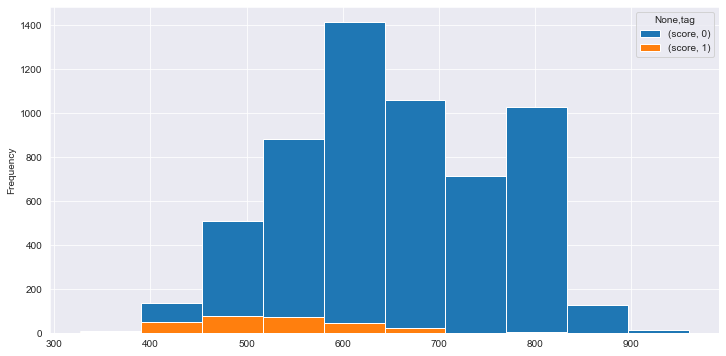

In [60]:
pd.pivot_table(data=score[['tag','score']],index=score.index,values=['score'],columns=['tag']).plot.hist(figsize=(12,6))

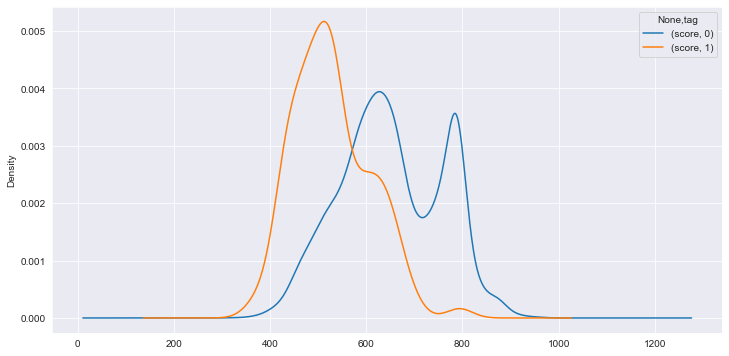

In [61]:
pd.pivot_table(data=score[['tag','score']],index=score.index,values=['score'],columns=['tag']).plot.kde(figsize=(12,6))

In [62]:
train_score = sc.scorecard_ply(tra_x,score_card_info,only_total_score=False)
test_oot_score =  sc.scorecard_ply(test_x[test_x['oot']==1],score_card_info,only_total_score=False)
test_dt_score = sc.scorecard_ply(test_x[test_x['oot']==0],score_card_info,only_total_score=False)
test_score = sc.scorecard_ply(test_x,score_card_info,only_total_score=False)
all_score = sc.scorecard_ply(pd.concat([tra_x,test_x]),score_card_info,only_total_score=False)

In [89]:
# score['授信申请编号'] = main_dataset['授信申请编号']
score.to_excel('final_result_2/score.xlsx',index=False)

In [87]:
# 2021年1月05日新增划分评分
score['bins'] = pd.cut(score['score'],bins=[326, 366, 406, 446, 486, 503, 514, 524, 534, 544, 549, 585, 614, 637,662,711, 762, 789, 960])
score_counts = score[['tag','score','bins']]
score_counts.groupby('bins').agg(total = ('tag','count'),bad=('tag','sum')).assign(
        good = lambda x:x.total-x.bad,
        BadRate = lambda x: x.bad/(x.bad+x.good),
        DistrBad = lambda x: x.bad/sum(x.bad),
        DistrGood = lambda x: x.good/sum(x.good)
).to_csv('final_result_2/细分得分情况.csv',encoding='gbk')
# [i for i in range(326,504,40)]


In [ ]:
# 时间外评估
psi_info_oot = sc.perf_psi(score={'train':train_score,'test':test_oot_score},label={'train':tra_y,'test':test_y_oot})
psi_info_oot['psi'].set_index('variable').sort_values(by=['PSI']).to_csv('final_result_2/时间外相对于训练集的PSI.csv',encoding='gbk')

In [ ]:
sc.iv(pd.concat([test_x_woe_oot,test_y_oot],axis=1),y='tag').to_csv('final_result_2/时间外特征IV.csv',encoding='gbk')

In [ ]:
score_counts = pd.concat([pd.qcut(test_oot_score['score'],10,duplicates='drop'),test_oot_score['score'],test_y_oot],axis=1)
score_counts.columns=['bins','score','tag']
score_counts.groupby('bins').agg(total = ('tag','count'),bad=('tag','sum')).assign(
        good = lambda x:x.total-x.bad,
        BadRate = lambda x: x.bad/(x.bad+x.good),
        DistrBad = lambda x: x.bad/sum(x.bad),
        DistrGood = lambda x: x.good/sum(x.good)
).to_csv('final_result_2/时间外得分情况.csv',encoding='gbk')

In [ ]:
# 测试集评估
psi_info_dt = sc.perf_psi(score={'train':train_score,'test':test_dt_score},label={'train':tra_y,'test':test_y_dt})
psi_info_dt['psi'].set_index('variable').sort_values(by=['PSI']).to_csv('final_result_2/测试集相对于训练集的PSI.csv',encoding='gbk')
sc.iv(pd.concat([test_x_woe_dt,test_y_dt],axis=1),y='tag').to_csv('final_result_2/测试集特征IV.csv',encoding='gbk')

In [ ]:
score_counts = pd.concat([pd.qcut(test_dt_score['score'],10),test_dt_score['score'],test_y_dt],axis=1)
score_counts.columns=['bins','score','tag']
score_counts.groupby('bins').agg(total = ('tag','count'),bad=('tag','sum')).assign(
        good = lambda x:x.total-x.bad,
        BadRate = lambda x: x.bad/(x.bad+x.good),
        DistrBad = lambda x: x.bad/sum(x.bad),
        DistrGood = lambda x: x.good/sum(x.good)
).to_csv('final_result_2/测试集得分情况.csv',encoding='gbk')

In [ ]:
# 训练集评估
score_counts = pd.concat([pd.qcut(train_score['score'],10),train_score['score'],tra_y],axis=1)
score_counts.columns=['bins','score','tag']
score_counts.groupby('bins').agg(total = ('tag','count'),bad=('tag','sum')).assign(
        good = lambda x:x.total-x.bad,
        BadRate = lambda x: x.bad/(x.bad+x.good),
        DistrBad = lambda x: x.bad/sum(x.bad),
        DistrGood = lambda x: x.good/sum(x.good)
).to_csv('final_result_2/训练集得分情况.csv',encoding='gbk')

In [ ]:
# 所有样本评估
score_counts = pd.concat([pd.qcut(all_score['score'],10),all_score['score'],pd.concat([tra_y,test_y])],axis=1)
score_counts.columns=['bins','score','tag']
score_counts.groupby('bins').agg(total = ('tag','count'),bad=('tag','sum')).assign(
        good = lambda x:x.total-x.bad,
        BadRate = lambda x: x.bad/(x.bad+x.good),
        DistrBad = lambda x: x.bad/sum(x.bad),
        DistrGood = lambda x: x.good/sum(x.good)
).to_csv('final_result_2/全部样本得分情况.csv',encoding='gbk')

In [ ]:
# 全部训练集
psi_info_test = sc.perf_psi(score={'train':train_score,'test':test_score},label={'train':tra_y,'test':test_y})
psi_info_test['psi'].set_index('variable').sort_values(by=['PSI']).to_csv('final_result_2/全部测试集相对于训练集的PSI.csv',encoding='gbk')
sc.iv(pd.concat([test_x_woe,test_y_oot],axis=1),y='tag').to_csv('final_result_2/全部测试集特征IV.csv',encoding='gbk')

In [ ]:
# 特征分布情况报告
import pandas_profiling
profile = pandas_profiling.ProfileReport(pd.concat([tra_x_woe,test_x_woe_dt,test_x_woe_oot]))
profile.to_file('final_result_2/output.html')

In [ ]:
tra_x_woe.corr().to_csv('final_result_2/corr.csv',encoding='gbk')

In [ ]:
check_vif(tra_x_woe)

In [ ]:
# 征信白户分数
score = pd.read_excel('final_result_2/score.xlsx')

In [ ]:
white_cust = pd.concat([score[['score','tag']],main_dataset['征信白户']],axis=1)

In [ ]:
white_cust.loc[white_cust['征信白户'] == 1,'score'].plot.kde(title='征信白户分数分布',figsize=(10,6))

In [ ]:
white_cust.to_csv('征信白户分数分布.csv',encoding='gbk')

In [ ]:
# 导出分箱结果

In [ ]:
fin_bin_df_dic = {k:d for k,d in rf_bins_dic.items() if k+'_woe' in tra_x_woe.columns}

In [ ]:
woe_score_dic = {c:pd.concat([tra_x_woe.append(test_x_woe)[c].value_counts().reset_index()['index'],
                   score[c.split('_woe')[0]+'_points'].value_counts().reset_index()['index']],axis=1) 
                 for c in tra_x_woe.columns}

with pd.ExcelWriter('woe_score.xlsx') as writer:
        for n,d in woe_score_dic.items():
            d.columns=['woe','score']
            nd = fin_bin_df_dic[n.split('_woe')[0]][['bin','woe']].merge(d)
            nd.to_excel(writer, sheet_name=n)

In [ ]:
score.index = main_dataset['授信申请编号']

In [ ]:
filter_cust = score[(score['score']>503)&(score['score']<=549)]

In [ ]:
sele_cust = main_dataset[main_dataset['授信申请编号'].isin(filter_cust.index)]

In [ ]:
sele_cust = sele_cust[[ '授信申请编号','近6月内查询机构数-贷款审批','近6月内查询机构数-信用卡审批','非银金融机构未结清贷款笔数',
                       '近5年累计逾期','近2月内查询机构数-贷款审批','mr_近6月内查询机构数-贷款审批','mr_近6月内查询机构数-信用卡审批',
                       'mr_近2月内查询机构数-贷款审批','mr_近5年累计逾期','mr_非银金融机构未结清贷款笔数',
                       '当前逾期','mr_当前逾期','tag']]

In [ ]:
sele_cust['近6月内查询机构数-贷款审批超过6个'] = 0
sele_cust.loc[sele_cust['近6月内查询机构数-贷款审批']>=6,'近6月内查询机构数-贷款审批超过6个'] = 1
sele_cust['近6月内查询机构数-信用卡审批超过6个'] = 0
sele_cust.loc[sele_cust['近6月内查询机构数-信用卡审批']>=6,'近6月内查询机构数-信用卡审批超过6个'] = 1
sele_cust['未结清高成本融资超过3笔'] = 0
sele_cust.loc[sele_cust['非银金融机构未结清贷款笔数']>=3,'未结清高成本融资超过3笔'] = 1
sele_cust['近5年累计逾期超过10次'] = 0
sele_cust.loc[sele_cust['近5年累计逾期']>10,'近5年累计逾期超过10次'] = 1

In [ ]:
sele_cust['标签1'] = 0
sele_cust.loc[sele_cust[['近6月内查询机构数-贷款审批超过6个','近6月内查询机构数-信用卡审批超过6个','未结清高成本融资超过3笔',
                        '近5年累计逾期超过10次','当前逾期']].sum(axis=1)>=2,'标签1'] = 1

In [ ]:
sele_cust['标签2'] = 0
sele_cust.loc[sele_cust['近2月内查询机构数-贷款审批']>=5,'标签2'] = 1

In [ ]:
sele_cust['标签3'] = 0
sele_cust.loc[sele_cust['近6月内查询机构数-贷款审批']>=8,'标签3'] = 1

In [ ]:
sele_cust['mr_近6月内查询机构数-贷款审批超过6个'] = 0
sele_cust.loc[sele_cust['mr_近6月内查询机构数-贷款审批']>=6,'mr_近6月内查询机构数-贷款审批超过6个'] = 1
sele_cust['mr_近6月内查询机构数-信用卡审批超过6个'] = 0
sele_cust.loc[sele_cust['mr_近6月内查询机构数-信用卡审批']>=6,'mr_近6月内查询机构数-信用卡审批超过6个'] = 1
sele_cust['mr_未结清高成本融资超过3笔'] = 0
sele_cust.loc[sele_cust['mr_非银金融机构未结清贷款笔数']>=3,'mr_未结清高成本融资超过3笔'] = 1
sele_cust['mr_近5年累计逾期超过10次'] = 0
sele_cust.loc[sele_cust['mr_近5年累计逾期']>10,'mr_近5年累计逾期超过10次'] = 1

In [ ]:
sele_cust['标签4'] = 0
sele_cust.loc[sele_cust[['mr_近6月内查询机构数-贷款审批超过6个','mr_近6月内查询机构数-信用卡审批超过6个','mr_未结清高成本融资超过3笔',
                        'mr_近5年累计逾期超过10次','mr_当前逾期']].sum(axis=1)>=2,'标签4'] = 1

In [ ]:
sele_cust_bad = sele_cust.loc[(sele_cust['tag']==1,sele_cust.columns.str.contains('标签|授信申请|tag'))]
sele_cust_good = sele_cust.loc[(sele_cust['tag']==0,sele_cust.columns.str.contains('标签|授信申请|tag'))]

In [ ]:
sele_cust_bad.to_csv('坏客户命中情况.csv',encoding='GBK')
sele_cust_good.to_csv('好客户命中情况.csv',encoding='GBK')

In [ ]:
sele_cust.to_csv('原始数据.csv',encoding='GBK')

In [ ]:
sele_cust_feas = main_dataset.loc[main_dataset['授信申请编号'].isin(sele_cust['授信申请编号']),[c.split('_points')[0] for c in score.columns if 'score' not in c]]
sele_cust_feas['授信申请编号'] = main_dataset.loc[sele_cust.index,'授信申请编号']
sele_cust_feas.to_csv('入模原始指标.csv',encoding='gbk')

In [ ]:
sele_cust_feas.loc[:,sele_cust_feas.columns.str.contains('逾期|查询')] = sele_cust_feas.fillna(0)
sele_cust_feas.to_csv('入模指标.csv',encoding='gbk')

In [ ]:
for c in sele_cust.columns:
    if ('编' in c )|('名称' in c)|('证' in c)|('时间' in c )|('tag' in c ):
        pass
    else:
        try:
            f = plt.figure()
            f = sele_cust[sele_cust['tag'] == 0][c].value_counts().plot.bar(title=c,figsize=(12,5),use_index=True)
            plt.savefig('distplot/good/{}'.format(c))
        except:
            pass

In [ ]:
sele_cust[sele_cust['tag'] == 1][c].value_counts()